In [1]:
# Load and Prepare Dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import DistilBertTokenizer, TFDistilBertModel

In [3]:
file_path = "C:/Users/atika/CS/Combined Data.csv"
data = pd.read_csv(file_path, encoding='latin1')
print("Dataset loaded successfully!")

Dataset loaded successfully!


In [5]:
# Drop missing values
data = data.dropna(subset=['statement']).reset_index(drop=True)

# Normalize text (lowercase)
data['statement'] = data['statement'].str.lower()

In [7]:
# Encode class labels
label_encoder = LabelEncoder()
data['status_encoded'] = label_encoder.fit_transform(data['status'])

C:\Users\atika\AppData\Local\Temp\ipykernel_11256\4111752818.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=data['status'], order=data['status'].value_counts().index, palette='Set2')


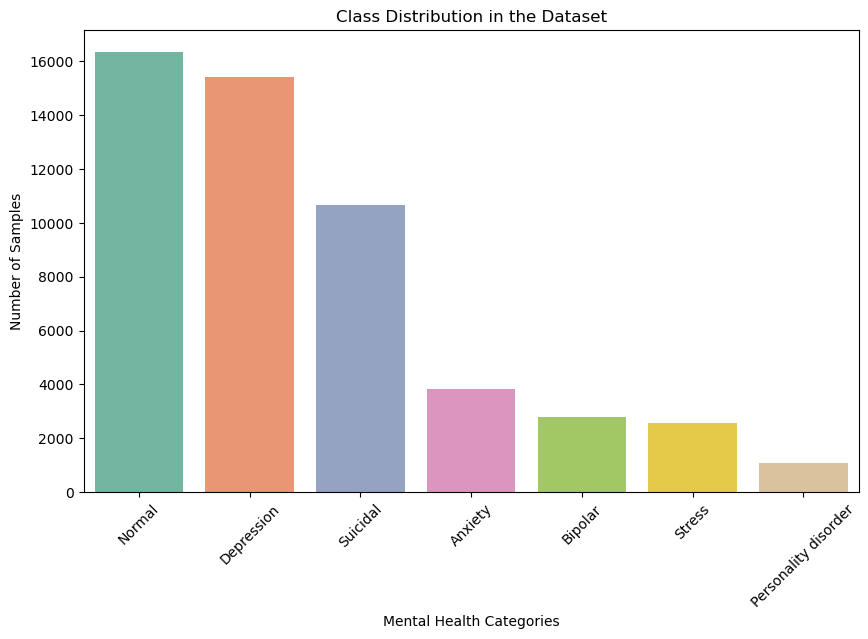

In [9]:
# Visualize class distribution
plt.figure(figsize=(10, 6))
sns.countplot(x=data['status'], order=data['status'].value_counts().index, palette='Set2')
plt.title('Class Distribution in the Dataset')
plt.xlabel('Mental Health Categories')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
plt.show()


In [11]:
# Balance dataset by downsampling
min_count = data['status'].value_counts().min()
balanced_data = data.groupby('status').apply(lambda x: x.sample(min_count, random_state=42)).reset_index(drop=True)

C:\Users\atika\AppData\Local\Temp\ipykernel_11256\2316567170.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_data = data.groupby('status').apply(lambda x: x.sample(min_count, random_state=42)).reset_index(drop=True)


In [13]:
import nltk
import re
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('omw-1.4')
lemmatizer = WordNetLemmatizer()
from nltk.corpus import stopwords

# Preprocess text: Lowercasing, removing special characters, and optional stopword removal
stop_words = set(stopwords.words('english')) 
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\W', ' ', text)  
    text = re.sub(r'\s+', ' ', text)  
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

data['statement'] = data['statement'].apply(clean_text)
print("Successful")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\atika\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\atika\AppData\Roaming\nltk_data...


Successful


C:\Users\atika\AppData\Local\Temp\ipykernel_11256\2905506737.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=balanced_data['status'], order=balanced_data['status'].value_counts().index, palette='Set2')


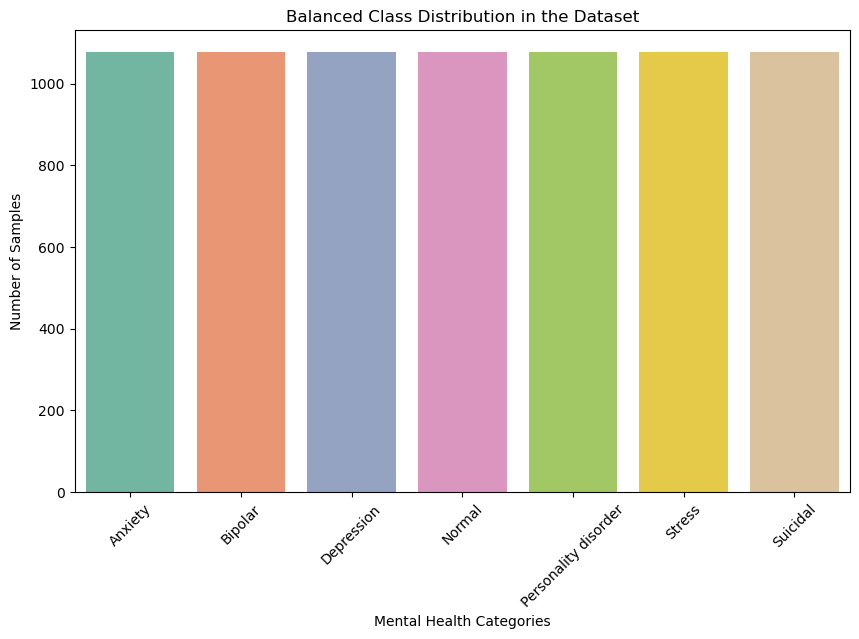

In [15]:
# Visualize balanced class distribution
plt.figure(figsize=(10, 6))
sns.countplot(x=balanced_data['status'], order=balanced_data['status'].value_counts().index, palette='Set2')
plt.title('Balanced Class Distribution in the Dataset')
plt.xlabel('Mental Health Categories')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
plt.show()

In [17]:

# Shuffle balanced dataset
balanced_data = balanced_data.sample(frac=1, random_state=42).reset_index(drop=True)


In [19]:
#Tokenization with DistilBERT
X = list(balanced_data['statement'])
y = list(balanced_data['status_encoded'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Use a smaller model and shorter max length for speed
max_len = 64
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
train_encodings = tokenizer(X_train, truncation=True, padding=True, max_length=max_len)
test_encodings = tokenizer(X_test, truncation=True, padding=True, max_length=max_len)

# Create TensorFlow Datasets
BATCH_SIZE = 32
train_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'input_ids': train_encodings['input_ids'],
        'attention_mask': train_encodings['attention_mask']
    },
    y_train
)).shuffle(1000).batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'input_ids': test_encodings['input_ids'],
        'attention_mask': test_encodings['attention_mask']
    },
    y_test
)).batch(BATCH_SIZE)

In [21]:
from tensorflow.keras.layers import Input, Dense, Dropout, Layer
from tensorflow.keras.models import Model

# Load pretrained DistilBERT
distilbert = TFDistilBertModel.from_pretrained('distilbert-base-uncased')

# Custom Keras layer to use DistilBERT
class DistilBertCLSLayer(Layer):
    def __init__(self, distilbert_model, **kwargs):
        super().__init__(**kwargs)
        self.distilbert = distilbert_model

    def call(self, inputs):
        outputs = self.distilbert(inputs)
        cls_token = outputs.last_hidden_state[:, 0, :]  # First token (CLS)
        return cls_token

    def compute_output_shape(self, input_shape):
        return (input_shape['input_ids'][0], 768)

# Define model input layers
input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
attention_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")

# Apply the custom DistilBERT layer
cls_output = DistilBertCLSLayer(distilbert)(
    {'input_ids': input_ids, 'attention_mask': attention_mask}
)

# Classification head
x = Dropout(0.3)(cls_output)
output = Dense(7, activation='softmax')(x)

# Build and compile model
model = Model(inputs=[input_ids, attention_mask], outputs=output)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [23]:
# Section 5: Training
import time
start = time.time()
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=15,
    callbacks=[early_stop, reduce_lr]
)
print("Training Time: {:.2f} seconds".format(time.time() - start))

Epoch 1/15
189/189 ━━━━━━━━━━━━━━━━━━━━ 450s 2s/step - accuracy: 0.2768 - loss: 1.8352 - val_accuracy: 0.5113 - val_loss: 1.3914 - learning_rate: 0.0010
Epoch 2/15
189/189 ━━━━━━━━━━━━━━━━━━━━ 449s 2s/step - accuracy: 0.4769 - loss: 1.4084 - val_accuracy: 0.5643 - val_loss: 1.2662 - learning_rate: 0.0010
Epoch 3/15
189/189 ━━━━━━━━━━━━━━━━━━━━ 276s 1s/step - accuracy: 0.5231 - loss: 1.3174 - val_accuracy: 0.5690 - val_loss: 1.2184 - learning_rate: 0.0010
Epoch 4/15
189/189 ━━━━━━━━━━━━━━━━━━━━ 219s 1s/step - accuracy: 0.5532 - loss: 1.2357 - val_accuracy: 0.5902 - val_loss: 1.1747 - learning_rate: 0.0010
Epoch 5/15
189/189 ━━━━━━━━━━━━━━━━━━━━ 217s 1s/step - accuracy: 0.5517 - loss: 1.2225 - val_accuracy: 0.6041 - val_loss: 1.1468 - learning_rate: 0.0010
Epoch 6/15
189/189 ━━━━━━━━━━━━━━━━━━━━ 217s 1s/step - accuracy: 0.5672 - loss: 1.1871 - val_accuracy: 0.6021 - val_loss: 1.1375 - learning_rate: 0.0010
Epoch 7/15
189/189 ━━━━━━━━━━━━━━━━━━━━ 216s 1s/step - accuracy: 0.5734 - loss: 1.

In [25]:
# Section 6: Evaluation
from sklearn.metrics import classification_report
import numpy as np

# Predict
preds = model.predict(test_dataset)
y_pred = np.argmax(preds, axis=1)

print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))


48/48 ━━━━━━━━━━━━━━━━━━━━ 43s 885ms/step
                      precision    recall  f1-score   support

             Anxiety       0.64      0.66      0.65       215
             Bipolar       0.75      0.57      0.65       215
          Depression       0.56      0.48      0.52       215
              Normal       0.83      0.88      0.85       216
Personality disorder       0.58      0.64      0.61       216
              Stress       0.57      0.57      0.57       215
            Suicidal       0.59      0.70      0.64       216

            accuracy                           0.64      1508
           macro avg       0.64      0.64      0.64      1508
        weighted avg       0.64      0.64      0.64      1508



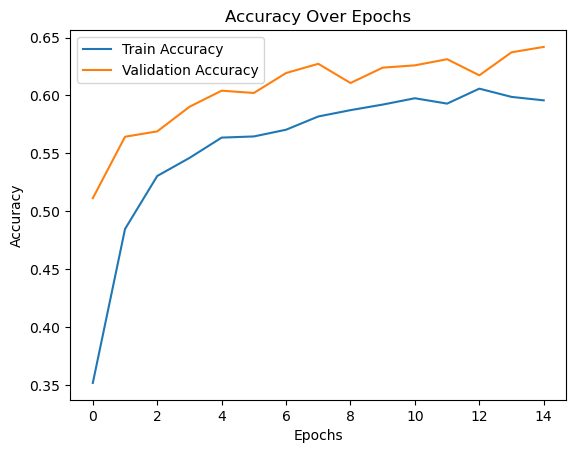

In [27]:
# Section 7: Visualization
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')
plt.show()

In [ ]:
# Save model
model.save('my_model.keras')

print("Model saved successfully.")
